In [1]:
from math import log, exp
ln = log
import random
from pprint import pprint
import numpy as np
from collections import defaultdict
%matplotlib inline
from matplotlib import pyplot

In [2]:
def random_choice(choices, weights=None):
    """ Select a random element in choices using a as weights. """
    if weights is None:
        weights = [1 for _ in range(len(choices))]
    r2 = random.random()
    breaking_point = r2*sum(weights)
    j = 0
    sum_j = weights[j]
    while sum_j < breaking_point:
        j += 1
        sum_j += weights[j]
    return choices[j]

In [16]:
def throttled_ssa(rate_constants, throttle_func=None, N_steps_max=100000, time_max=None, start_state=None):
    """ Minimal stochastic simulation algorithm. rate_constants: dict of dicts, [start][end] = k(start->end) """
    time, N_steps, stats = 0, 0, []
    state_count = {k: 0 for k in rate_constants.keys()}
    reaction_count = {(source, target): 0 
                      for source, targets in rate_constants.items() for target in targets.keys()}
    cycle_count = {k: 0 for k in rate_constants.keys()}

    if throttle_func is None:
        throttle_func = lambda state, end_state, state_counts, cycle_counts, reaction_count: 1
    state = start_state if start_state is not None else random.choice(list(rate_constants.keys()))
    while N_steps < N_steps_max and (time_max is None or time < time_max):
        #end_states, a = zip(*rate_constants[state].items())
        end_states, a = zip(*[(end_state, k*throttle_func(state, end_state, state_count, cycle_count, reaction_count)) 
                              for end_state, k in rate_constants[state].items()])
        tau = ln(1/random.random())/sum(a)  # or np.random.exponential(1/sum(a))
        end_state = random_choice(end_states, weights=a)
        stats.append({'state': state, 'tau': tau, 'time': time})
        state_count[state] += 1
        reaction_count[(state, end_state)] += 1
        state = end_state
        time += tau
        N_steps += 1
    state_times = {state: sum(step['tau'] for step in stats if step['state'] == state)
                   for state in rate_constants.keys()}
    result = dict(zip("stats, cycle_count, state_count, time, state".split(", "),
                      [stats, cycle_count, state_count, time, state]))
    return stats
minimal_ssa = throttled_ssa

In [17]:
def state_times(stats, states):
    return {state: sum(step['tau'] for step in stats if step['state'] == state) for state in states}

def plot_time_partitions(stats, states):
    # state_partitions = state_times(stats, states)
    state_partitions = {state: sum(step['tau'] for step in stats if step['state'] == state) for state in rates.keys()}
    times = [state_partitions[state] for state in states]
    indices = range(len(states))
    barwidth = 0.5
    ax = pyplot.bar(indices, times, width=barwidth, alpha=0.5)
    ticks = pyplot.xticks([i+barwidth/2 for i in indices], states)
    xlims = pyplot.xlim(xmin=-0.1)
    title = pyplot.title('Cumulative state time')


In [32]:
# throttled_ssa(rate_constants, throttle_func=None, N_steps_max=100000, time_max=None, start_state=None)
def simulate_n_times(N_sims, rates, throttle_func=None, N_steps_max=20000, start_state=""):
    Ks = []
    all_stats = []
    for i in range(N_sims):
        stats = minimal_ssa(rates, throttle_func=throttle_func, N_steps_max=N_steps_max, start_state=start_state)
        all_stats.append(stats)
        state_partitions = {state: sum(step['tau'] for step in stats if step['state'] == state) for state in rates.keys()}
        K = sum(state_partitions[state] for state in states if state != "")/state_partitions[""]
        Ks.append(K)
        print(".", end="")
    print("")
    return all_stats, Ks

Rate constants:
   ->  a: 1000.0
   ->  b: 1000.0
a  ->   : 18315.63888873418
a  -> ab: 1000000.0
ab ->  a: 49787.06836786395
ab ->abs: 1000000.0
ab ->  b: 18315.63888873418
abs-> ab: 496585.30379140953
b  ->   : 49787.06836786395
b  -> ab: 1000000.0

end_time: 0.177
N_stats: 100000
   : 0.189156
  a: 0.0132797
  b: 0.00454558
abs: 0.530839
 ab: 0.26218

K_on = 0.1435/0.03348 = 4.2866


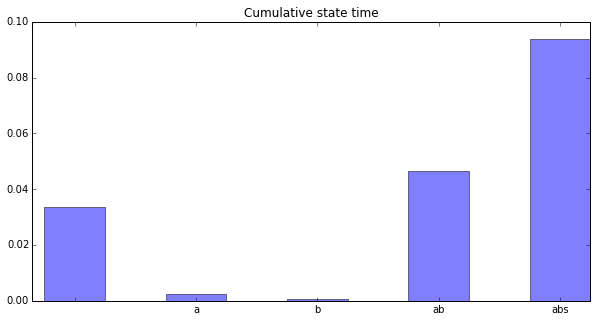

In [33]:
## Self-consistent two-domain binding:
## Emulates the "two-domain duplex hybridization and melting" case.
## Off-rates depends on energy (volume) *difference*, but on-rates does not.
## Volumes represent the whole system energy and are thus additive as the domains are hybridized/stacked.
dE = {'a': -4, 'b': -3, 's': -0.7} # in units of RT
states = ["", "a", "b", "ab", "abs"]
conc = 1e-3
k_on = 1e6
# K = k_on/k_off = exp(-dG/RT), k_off = k_on * exp(dG/RT)
"""
           ,----------.       
     ,--- a ---.       \      
    /           \       \     
  u              ab --- abs   
    \           /       /     
     `--- b ---´       /      
           `----------´       
"""
rates = {
            "": {"a": k_on*conc, "b": k_on*conc},
            "a": {"": k_on*exp(dE['a']), "ab": k_on},
            "b": {"": k_on*exp(dE['b']), "ab": k_on},
            "ab": {"a": k_on*exp(dE['b']), "b": k_on*exp(dE['a']), "abs": k_on},
            "abs": {"ab": k_on*exp(dE['s'])},
            #"abs": {"a": k_on*exp(dE['b']+dE['s']), "b": k_on*exp(dE['a']+dE['s'])},
        }
print("Rate constants:")
print("\n".join("{:<3}->{:>3}: {}".format(source, target, k) for source, targets in sorted(rates.items()) 
                for target, k in sorted(targets.items())))

stats = minimal_ssa(rates, N_steps_max=100000, start_state="")

print("\nend_time: %0.03g" % stats[-1]['time'])
print("N_stats: %s" % len(stats))
pyplot.figure(figsize=(10, 5))
plot_time_partitions(stats, states=states)
state_partitions = {state: sum(step['tau'] for step in stats if step['state'] == state) for state in rates.keys()}
P = sum(state_partitions.values())
#df = pd.DataFrame(state_partitions)
print("\n".join("{:>3}: {:04g}".format(state, p/P) for state, p in state_partitions.items()))
#print(df)
unhybridized = state_partitions[""]
hybridized = sum(state_partitions[state] for state in states if state != "")
print("\nK_on = %0.04g/%0.04g = %0.4f" % (hybridized, unhybridized, hybridized/unhybridized))

Thermodynamic/energetic equilibrium constants:
K( ab/   ) = 1.1e+03
K(abs/   ) = 3.64e+03
..................................................
..................................................
..................................................
..................................................


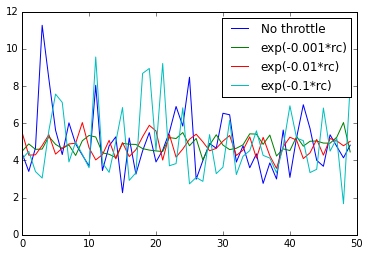

In [38]:
N_sims = 50
N_steps_max = 40000

dE = {'a': -3, 'b': -4, 's': -1.2} # in units of RT
states = ["", "a", "b", "ab", "abs"]
state_energies = {"": 0, "a": dE['a'], "b": dE['b'], "ab": dE['a']+dE['b'], "abs": dE['a']+dE['b']+dE['s']}

rates = {
            "": {"a": k_on*conc, "b": k_on*conc},
            "a": {"": k_on*exp(dE['a']), "ab": k_on},
            "b": {"": k_on*exp(dE['b']), "ab": k_on},
            "ab": {"a": k_on*exp(dE['b']), "b": k_on*exp(dE['a']), "abs": k_on},
            "abs": {"ab": k_on*exp(dE['s'])},
            #"abs": {"a": k_on*exp(dE['b']+dE['s']), "b": k_on*exp(dE['a']+dE['s'])},
        }

print("Thermodynamic/energetic equilibrium constants:")
K = {(target, source): exp(state_energies[source]-state_energies[target]) 
     for source, target in (("", "a"), ("", "b"), ("", "ab"), ("", "abs"),
                            ("a", "ab"), ("ab", "abs"), ("a", "abs"))}
print("\n".join("K(%3s/%3s) = %0.03g" % (target, source, exp(state_energies[source]-state_energies[target]))
                for source, target in (("", "ab"), ("", "abs"))))

## No throttle:
all_stats, Ks = simulate_n_times(N_sims, rates, throttle_func=None)
pyplot.plot(Ks, label="No throttle")


## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.001*reaction_count[(state, end_state)])
all_stats, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.001*rc)")

## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.01*reaction_count[(state, end_state)])
all_stats, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.01*rc)")

## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.1*reaction_count[(state, end_state)])
all_stats, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.1*rc)")


## Finishing touch: 
#pyplot.ylim(ymin=0, ymax=1.3*max((max(K_abs_a), max(K_abs_a2), max(K_abs_a3))))
pyplot.legend()
#print("abs -> ab: avg=%.03f, std=%.03f" % (np.average(Ks), np.std(Ks)))
